# Outliers notebook

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/outliers.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of outliers handling using ETNA library.

**Table of Contents**

* [Uploading dataset](#chapter1)  
* [Point outliers](#chapter2)
    * [Median method](#section_2_1)
    * [Density method](#section_2_2)
    * [Prediction interval method](#section_2_3)
    * [Histogram method](#section_2_4)
* [Interactive visualization](#chapter3)
* [Outliers imputation](#chapter4)

In [1]:
import warnings
warnings.filterwarnings("ignore")

### 1. Uploading dataset <a class="anchor" id="chapter1"></a>

In [2]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset

Let's load and look at the dataset

In [3]:
classic_df = pd.read_csv("data/example_dataset.csv")
df = TSDataset.to_dataset(classic_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


As you can see from the plots, all the time series contain outliers - abnormal spikes on the plot.

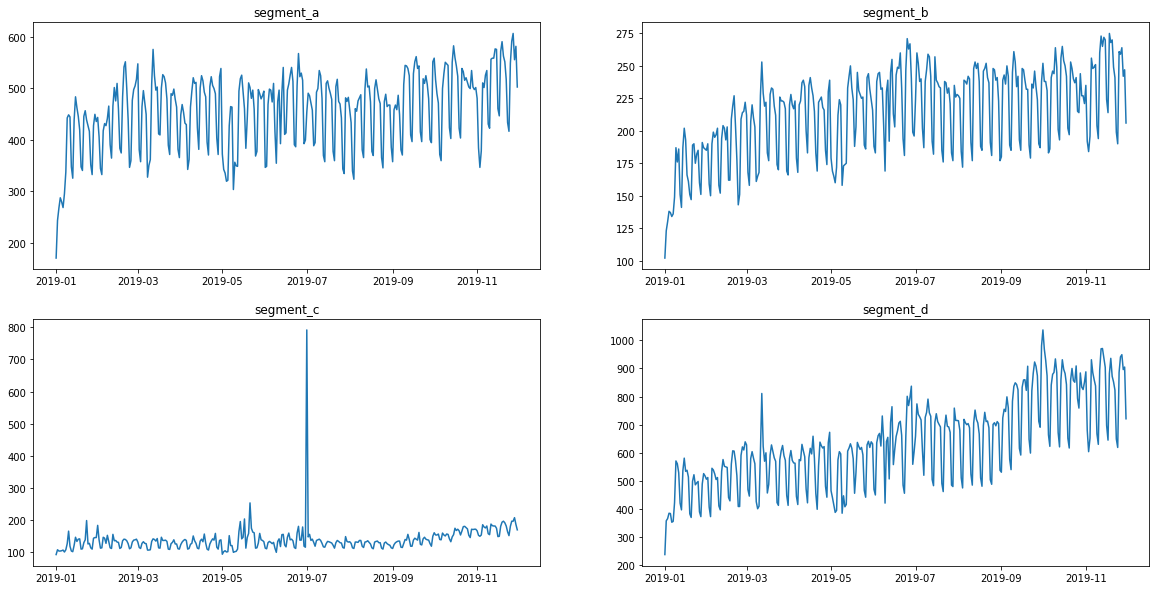

In [4]:
ts.plot()

In our library, we provide methods for point and sequence outliers **detection**, **visualization** and **imputation**. In the sections below, you will find an overview of the outliers handling tools.

### 2. Point outliers<a class="anchor" id="chapter2"></a>
Point outliers are stand alone abnormal spikes on the plot. Our library contains four methods for their detection based on different principles. The choice of the method depends on the dataset. 

In [5]:
from etna.analysis.outliers import (
    get_anomalies_median,
    get_anomalies_density,
    get_anomalies_prediction_interval,
    get_anomalies_hist)
from etna.analysis import plot_anomalies

*Note*: you can specify the column in which you want search for anomalies using the `in_column` argument.

#### 3.1 Median method<a class="anchor" id="section_2_1"></a>
To obtain the point outliers using the median method we need to specify the *window* for fitting the median model.

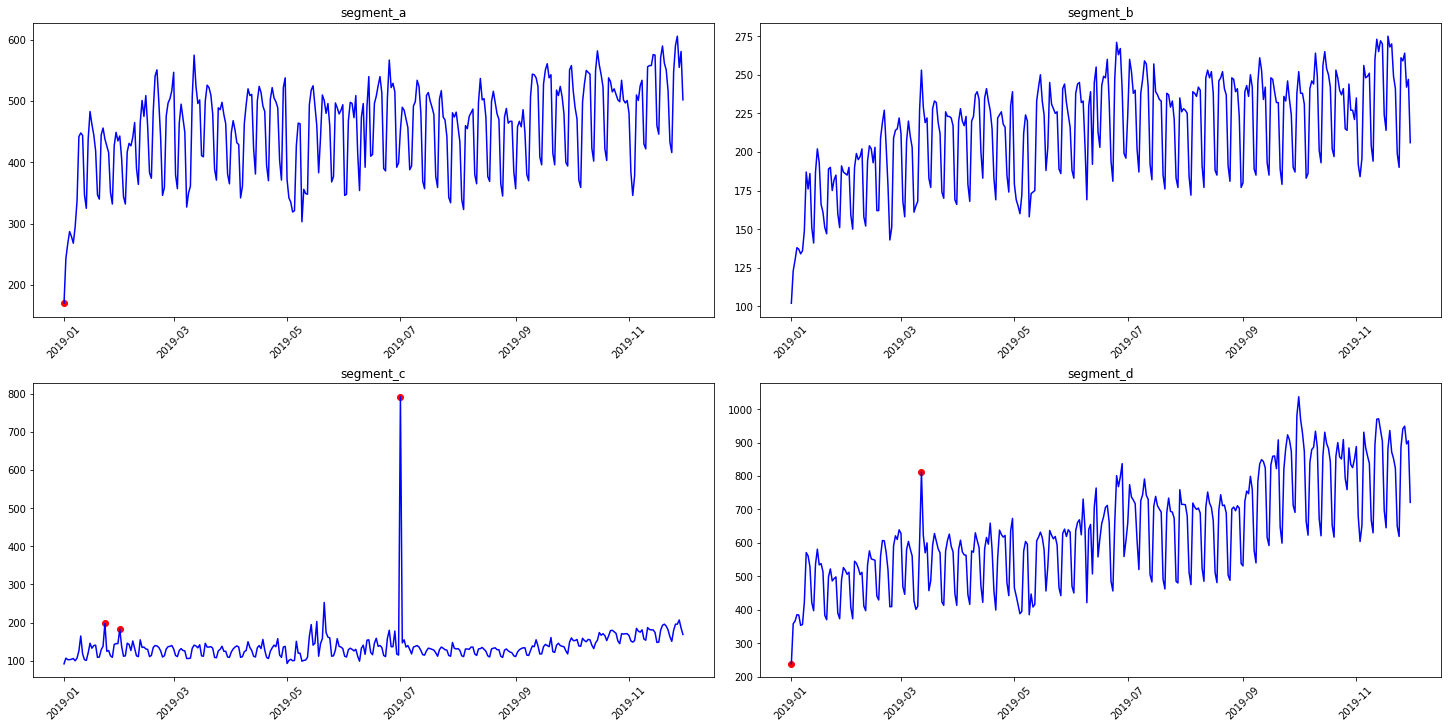

In [6]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

#### 3.2 Density method<a class="anchor" id="section_2_2"></a>
It is a distance-based method for outliers detection. 

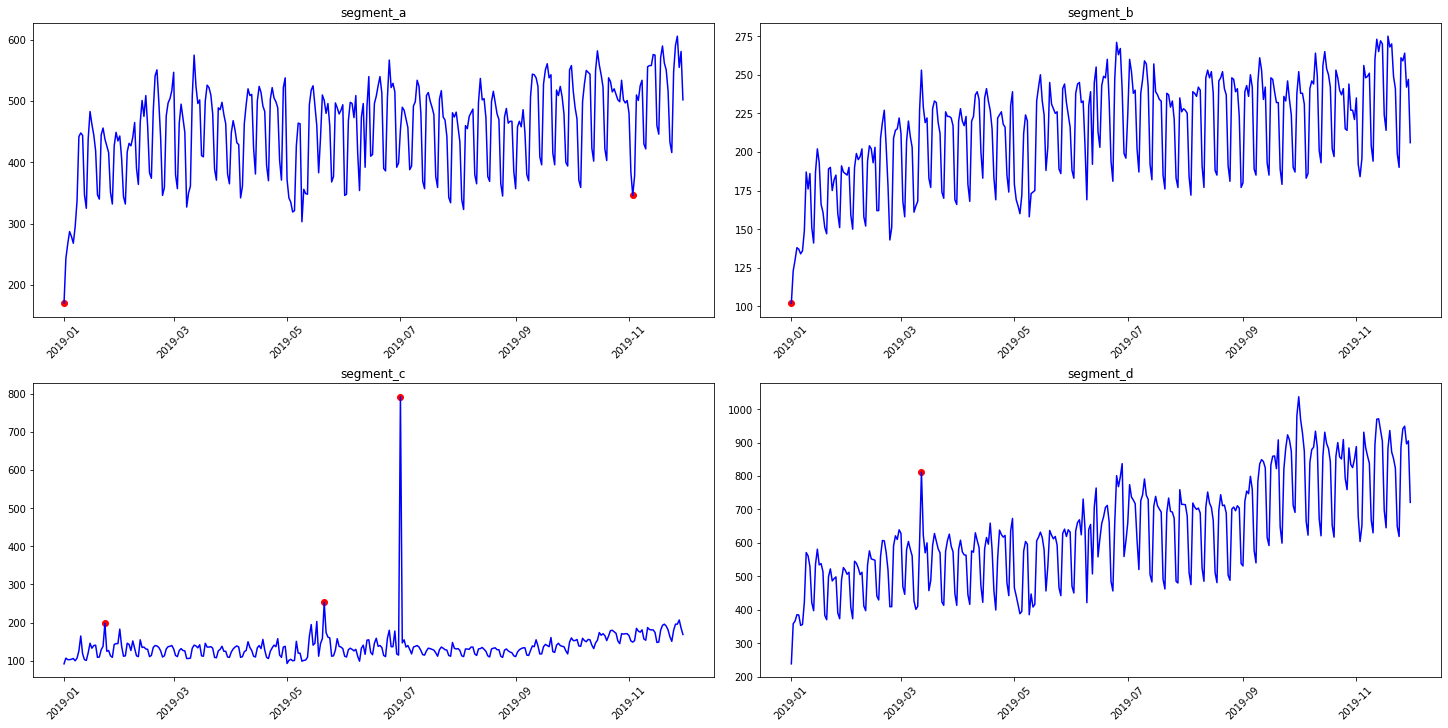

In [7]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

#### 3.3 Prediction interval method<a class="anchor" id="section_2_3"></a>
It is a model-based method for outliers detection. Outliers here are all points out of the prediction interval predicted with the `model`. 

*Note*: method is now available only for `ProphetModel` and `SARIMAXModel`.

In [8]:
from etna.models import ProphetModel

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.6574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       717.862   5.47762e-05       70.3373      0.7318      0.7318      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184         718.9   0.000777412       57.0119   1.148e-05       0.001      283  LS failed, Hessian reset 
     199        718.95   0.000169166       68.2339      0.4166      0.4166      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.115   9.88345e-08       61.9643      0.7779      0.7779      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       719.115   3.03745e-08       50.9058      0.8913      0.8913      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

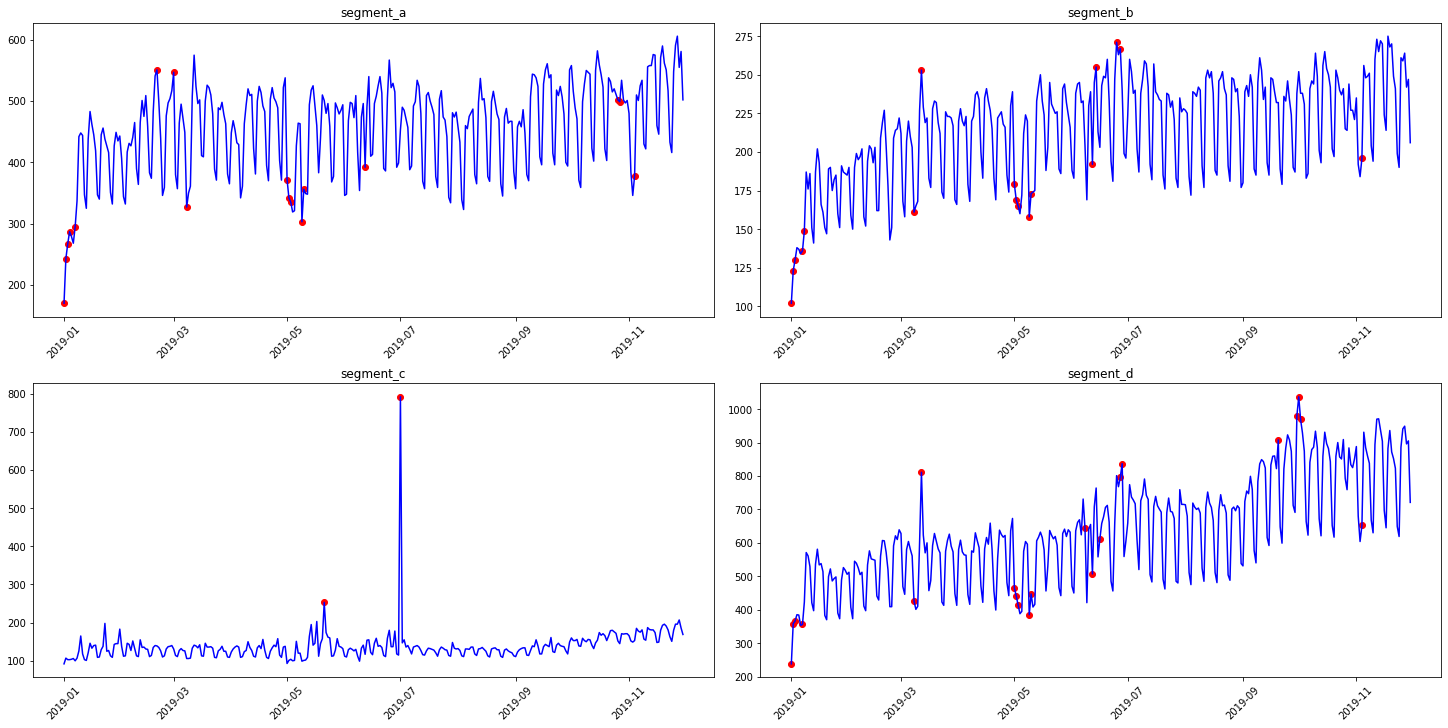

In [9]:
anomaly_dict = get_anomalies_prediction_interval(ts, model=ProphetModel, interval_width=0.95)
plot_anomalies(ts, anomaly_dict)

#### 3.4 Histogram method<a class="anchor" id="section_2_4"></a>
This method detects outliers in time series using histogram model. Outliers here are all points that, when removed, result in a histogram with a lower approximation error.

*Note*: method might work sufficiently slow.

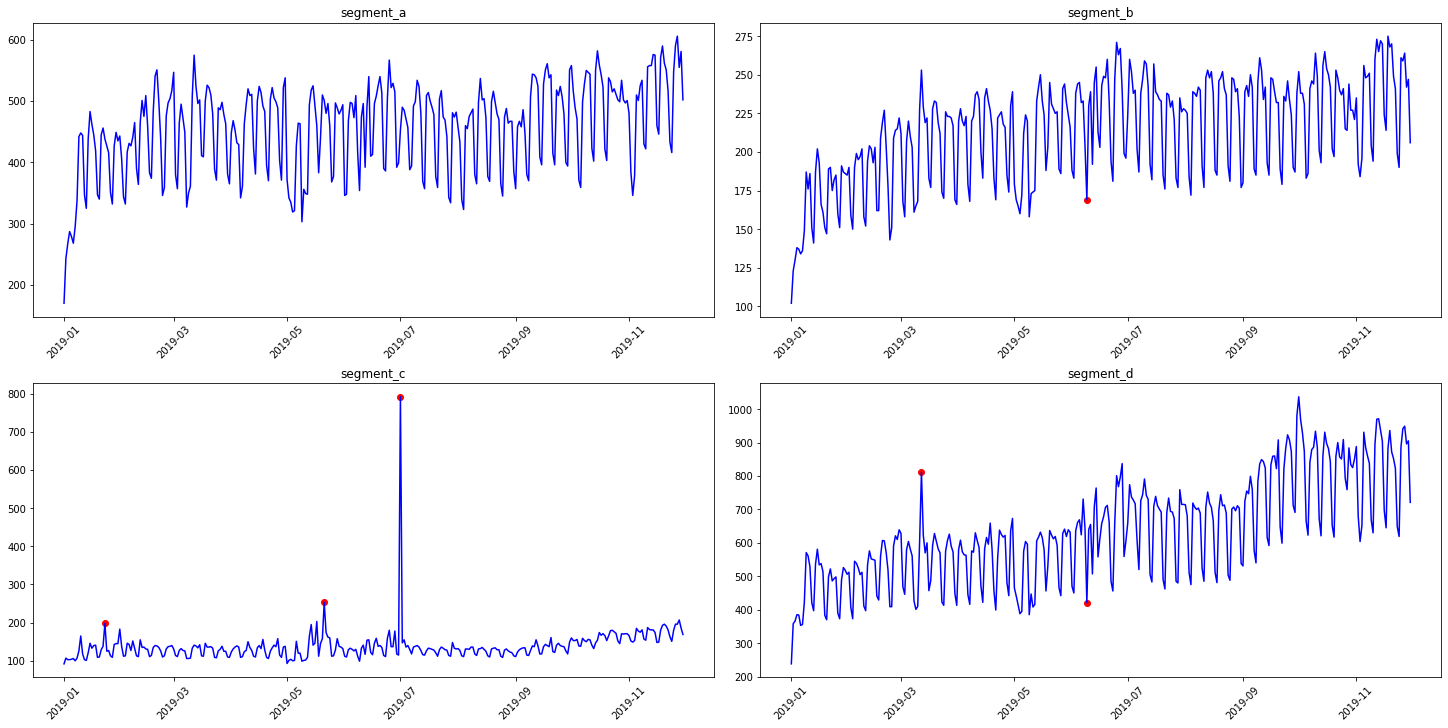

In [10]:
anomaly_dict = get_anomalies_hist(ts, bins_number=10)
plot_anomalies(ts, anomaly_dict)

### 3. Interactive visualization<a class="anchor" id="chapter3"></a>
The performance of outliers detection methods significantly depends on their hyperparameters values. To select the best parameters' configuration for the chosen method, you can use our interactive visualization tool.

In [11]:
from etna.analysis import plot_anomalies_interactive

You only need to specify **segment**, the outliers detection **method** and it's **parameters grid** in format (min, max, step) for each parameter you want to control.

In [12]:
segment = "segment_c"
method = get_anomalies_median
params_bounds = {"window_size": (40, 70, 1),
                 "alpha": (0.1, 4, 0.25)}

In some cases there might be troubles with this visualisation in Jupyter notebook, try to use `!jupyter nbextension enable --py widgetsnbextension`

In [13]:
plot_anomalies_interactive(ts=ts,segment=segment,method=method,params_bounds=params_bounds)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', max=70, min=40, …

Let's assume that the best parameters are:

In [14]:
best_params = {"window_size":60,
              "alpha":2.35}

### 4. Outliers imputation<a class="anchor" id="chapter4"></a>
The previous sections are focused on the outliers detection as the part of the EDA, however outliers imputation might be also one of the step in the pipeline of your forecasting model. Let's explore a simple example of how to build such pipeline.

In [15]:
from etna.transforms import MedianOutliersTransform, TimeSeriesImputerTransform

Segment with outliers:

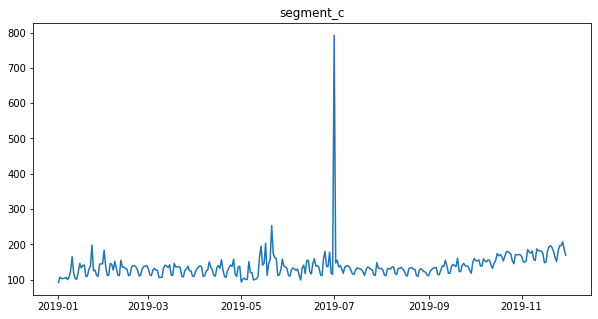

In [16]:
df = ts[:,segment,:]
ts = TSDataset(df, freq="D")
ts.plot()

Outliers imputation process consists of two steps:
1. Replace the outliers, detected by the specific method, with NaNs using the instance of the corresponding *OutliersTransform*
2. Impute NaNs using the *TimeSeriesImputerTransform*

Let's impute outliers detected by *median* method using the *running_mean* imputation strategy.

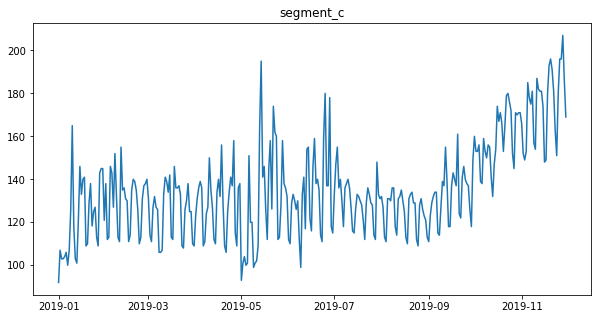

In [17]:
# Impute outliers with NaNs
outliers_remover = MedianOutliersTransform(in_column="target",**best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(in_column="target",strategy="running_mean",window=30)
ts.fit_transform([outliers_remover,outliers_imputer])
ts.plot()

Now you can fit the model on the cleaned dataset, which might improve the forecasting quality. Let's compare the forecasts of the model fitted on cleaned and uncleaned train timeseries.

In [18]:
from etna.models import MovingAverageModel
from etna.pipeline import Pipeline
from etna.metrics import MAE,MSE,SMAPE

In [19]:
def get_metrics(forecast,test):
    """Compute the metrics on forecast"""
    metrics = {"MAE":MAE(),"MSE":MSE(),"SMAPE":SMAPE()}
    results = dict()
    for name,metric in metrics.items():
        results[name] = metric(y_true=test, y_pred=forecast)["segment_c"]
    return results  

In [20]:
def test_transforms(transforms=[]):
    """Run the experiment on the list of transforms"""
    classic_df = pd.read_csv("data/example_dataset.csv")
    df = TSDataset.to_dataset(classic_df[classic_df["segment"]==segment])
    ts = TSDataset(df, freq="D")
    train,test = ts.train_test_split(train_start="2019-05-20",
                                 train_end="2019-07-10",
                                 test_start="2019-07-11",
                                 test_end="2019-08-09")
    
    model = Pipeline(model=MovingAverageModel(window=30),transforms=transforms,horizon=30)
    model.fit(train)
    forecast = model.forecast()
    metrics = get_metrics(forecast,test)
    return metrics
    

Results on the uncleaned dataset:

In [21]:
test_transforms()

{'MAE': 40.08799715116714,
 'MSE': 1704.8554888537708,
 'SMAPE': 27.36913416466395}

Results on the cleaned dataset(we impute outliers in train part and predict the test part):

In [22]:
transforms = [outliers_remover,outliers_imputer]
test_transforms(transforms)

{'MAE': 11.606826505006092,
 'MSE': 196.5736131226554,
 'SMAPE': 8.94919204071121}

As you can see, there is significant improvement in the metrics in our case. However, the points that we defined as the outliers may occur to be the points of complex timeseries behavior. In this case, outliers imputation might make the forecast worse.